In [2]:
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# some colors
mainblue = ["#42719f", "#6ab4ff"]
coralgreen = ["#117a65", "#138D75"]
reddish = ["#c82929", "#e42f2f"]
orangish = ["#d78939", "#e48a2f"]
blueish = ["#4387cb", "#2f89e4"]


from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import norm

In [44]:
activations_file = '../../results/fourTag_10x_z_6_epoch_025.pkl'

z = torch.load(activations_file)["activations"]
z = z.numpy()
# Get the number of features
dimension = z.shape[1]
# Determine the grid layout based on the number of features
if dimension <= 4:
    num_rows = 2
    num_cols = 2
elif dimension <= 6:
    num_rows = 2
    num_cols = 3
elif dimension <= 9:
    num_rows = 3
    num_cols = 3 
elif dimension <= 12:
    num_rows = 3
    num_cols = 4
elif dimension <= 16:
    num_rows = 4
    num_cols = 4
else:
    raise ValueError("The number of features is too high to display in a reasonable way.")

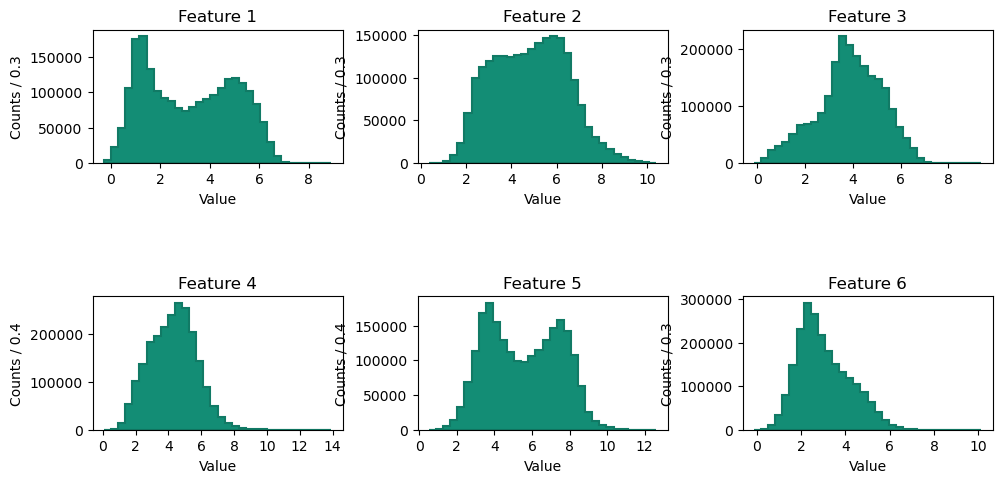

In [45]:
# plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,5))
#fig.suptitle(f"Histograms of {dimension} Different Features", fontsize=16)
axs = axs.flatten()
h, bins = np.zeros_like(axs), np.zeros_like(axs)

if (dimension < num_rows * num_cols):
    for j in range(1, num_rows*num_cols - dimension + 1):
        axs[-j].axis('off')  # Hide any empty subplots

# Plot histograms for each feature
for i in range(dimension):
    ax = axs[i]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    h[i], bins[i], _ = ax.hist(z[:, i], bins = 32, alpha=1, color='blue', density = False, histtype='stepfilled', linewidth = plt.rcParams["lines.linewidth"], edgecolor = coralgreen[0], facecolor = coralgreen[1])
    ax.set_title(f"Feature {i+1}")
    ax.set_xlabel("Value")
    ax.set_ylabel(f"Counts / {(bins[i][1]-bins[i][0]):.1f}")

# layout
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.3, hspace = 1.)

In [43]:
def GMM_sample(z, max_nb_gaussians = 2, debug = False, **kwargs):
    dimension = z.shape[1]
    print(dimension)
    z = z.numpy()
    z_sampled = np.zeros_like(z) # create the final sampled activations
    if debug:
        sample = kwargs.get('sample')
        import matplotlib.pyplot as plt
        # create necessary things to plot
        # Determine the grid layout based on the number of features
        if dimension <= 4:
            num_rows = 2
            num_cols = 2
        elif dimension <= 6:
            num_rows = 2
            num_cols = 3
        elif dimension <= 9:
            num_rows = 3
            num_cols = 3 
        elif dimension <= 12:
            num_rows = 3
            num_cols = 4
        elif dimension <= 16:
            num_rows = 4
            num_cols = 4
        else:
            raise ValueError("The number of features is too high to display in a reasonable way.")
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,8))
        axs = axs.flatten()
        if (dimension < num_rows * num_cols):
            for j in range(1, num_rows*num_cols - dimension + 1):
                axs[-j].axis('off')  # Hide any empty subplots
        h, bins = np.zeros_like(axs), np.zeros_like(axs)


    for d in range(dimension): 
        max_nb_gaussians = 2
        min_bic = 0
        counter = 1
        gmms, fits, bics = [], [], []
        for i in range (max_nb_gaussians): # test the AIC/BIC metric between 1 and max_nb_gaussians components
            gmm = GMM(n_components = counter, random_state=10, covariance_type = 'full')
            gmms.append(gmm)
            fits.append(gmm.fit(z[:,d]))
            #labels = fit.predict(z[:,0])
            bic = gmm.bic(z[:,d])
            bics.append(bic)
            if bic < min_bic or min_bic == 0:
                min_bic = bic
                n_opt = counter
            counter = counter + 1


        # get optimal GMM model
        gmm_opt = gmms[n_opt - 1]

        # get optimal parameters
        means_opt = fits[n_opt - 1].means_
        covs_opt  = fits[n_opt - 1].covariances_
        weights_opt = fits[n_opt - 1].weights_

        if debug:
            h[d], bins[d], _ = axs[d].hist(z[:,d], density=False, color='black', bins=32, histtype = 'step')
            x_ax = np.linspace(bins[d][0], bins[d][-1], 1000)
            y_axs = []
            for i in range(n_opt):
                y_axs.append(np.sum(h[d]*(bins[d][1:]-bins[d][:-1]))*norm.pdf(x_ax, float(means_opt[i][0]), np.sqrt(float(covs_opt[i][0][0])))*weights_opt[i]) # ith gaussian
                axs[d].plot(x_ax, y_axs[i])
            axs[d].plot(x_ax, np.sum(y_axs, axis = 0), ls='dashed', label = "GMM estimated PDF")
            axs[d].set_title(f'Feature {d+1}; opt. components = {n_opt}')
            axs[d].set_xlabel("Value")
            axs[d].set_ylabel(f"Counts / {(bins[d][1]-bins[d][0]):.1f}")


        # Sampling
        r_values = np.random.uniform(0, 1, len(z[:,d]))
        # Cumulative sum of weights to sample the identity of the gaussian
        weights_cum = np.cumsum(weights_opt)
        # Find the indices of the values in weights_cumulative that are immediately higher than 'r'
        gaussian_indices = np.searchsorted(weights_cum, r_values[:, np.newaxis], side='right')[:,0]
        # Use list comprehension to get the parazmeters for the corresponding Gaussian distributions
        mu = [float(means_opt[i][0]) for i in gaussian_indices]
        sigma = [np.sqrt(float(covs_opt[i][0][0])) for i in gaussian_indices]

        # Sample from the corresponding Gaussian distributions
        sampled_values = np.random.normal(mu, sigma)
        z_sampled[:,d,0] = sampled_values
        if debug:
            axs[d].hist(z_sampled[:,d], bins = bins[d], color = "red", density = False, histtype = 'step', ls = 'solid', label = "Sampled")
            # layout
            fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.3, hspace = 1.)
            path = f"plots/redec/{sample}/"
            plots.mkpath(path)
            fig.savefig(f'{path}{sample}_zsampled_{dimension}.pdf')
    return torch.tensor(z_sampled)

In [47]:
## using neighbors
from sklearn.neighbors import KernelDensity


# Flatten the data to perform KDE
flattened_z = z.reshape(-1, 6)

# Create the Kernel Density Estimation model with the Gaussian kernel
kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
kde.fit(flattened_z)

# Generate a new sample from the density-weighted distribution
num_samples = z.shape[0]  # Number of samples to generate
sampled_data = kde.sample(num_samples)

# Reshape the sampled data back to the original shape
sampled_data = sampled_data.reshape(num_samples, 6, 1)

print("Original shape of z:", z.shape)
print("Sampled data shape:", sampled_data.shape)

Original shape of z: (2202261, 6, 1)
Sampled data shape: (2202261, 6, 1)


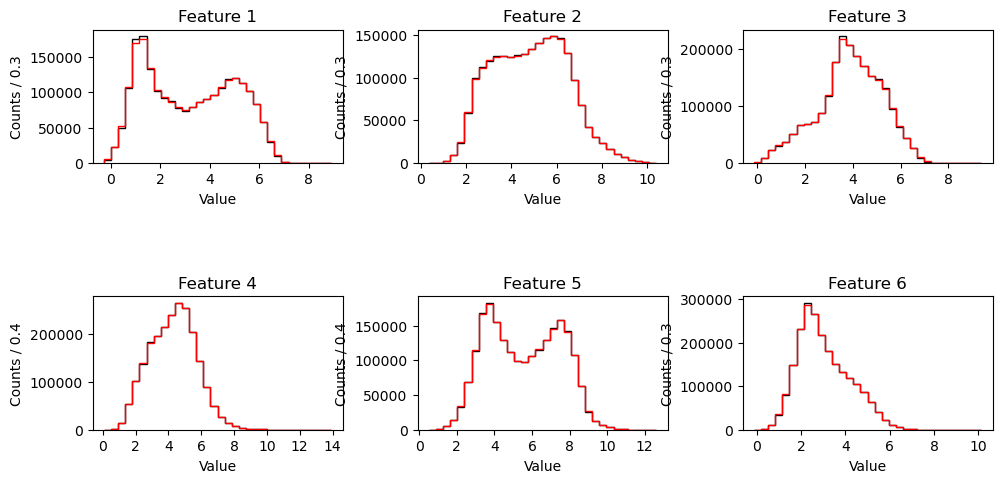

In [51]:
# plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,5))
#fig.suptitle(f"Histograms of {dimension} Different Features", fontsize=16)
axs = axs.flatten()
h, bins = np.zeros_like(axs), np.zeros_like(axs)

for i in range(dimension):
    ax = axs[i]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    h[i], bins[i], _ = ax.hist(z[:,i], density=False, color='black', bins=32, histtype = 'step')
    ax.hist(sampled_data[:,i], density=False, color='red', bins=bins[i], histtype = 'step')
    ax.set_title(f"Feature {i+1}")
    ax.set_xlabel("Value")
    ax.set_ylabel(f"Counts / {(bins[i][1]-bins[i][0]):.1f}")

# layout
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.3, hspace = 1.)

(array([[1.10000e+01, 4.71000e+02, 3.40400e+03, 1.01210e+04, 1.21910e+04,
         1.23090e+04, 9.11100e+03, 4.89500e+03, 9.91000e+02, 6.30000e+01],
        [8.80000e+01, 4.10800e+03, 2.25870e+04, 6.88360e+04, 9.86520e+04,
         1.12647e+05, 8.39080e+04, 4.61130e+04, 1.37880e+04, 1.76000e+03],
        [2.20000e+01, 1.14100e+03, 9.02200e+03, 3.79970e+04, 9.11440e+04,
         1.20519e+05, 6.35430e+04, 2.98530e+04, 9.59100e+03, 1.40200e+03],
        [1.31000e+02, 5.05000e+03, 2.19100e+04, 4.42120e+04, 7.61820e+04,
         7.37370e+04, 3.00520e+04, 5.77200e+03, 1.30600e+03, 1.17000e+02],
        [5.23000e+02, 2.09120e+04, 6.96430e+04, 8.06040e+04, 5.32850e+04,
         3.47150e+04, 2.42460e+04, 1.61000e+03, 2.15000e+02, 1.10000e+01],
        [8.13000e+02, 3.68060e+04, 1.22144e+05, 8.84700e+04, 4.16690e+04,
         3.84960e+04, 3.57580e+04, 1.26800e+03, 4.60000e+01, 1.00000e+00],
        [7.26000e+02, 2.60930e+04, 9.55080e+04, 6.45490e+04, 4.03770e+04,
         5.81750e+04, 3.85070e+0

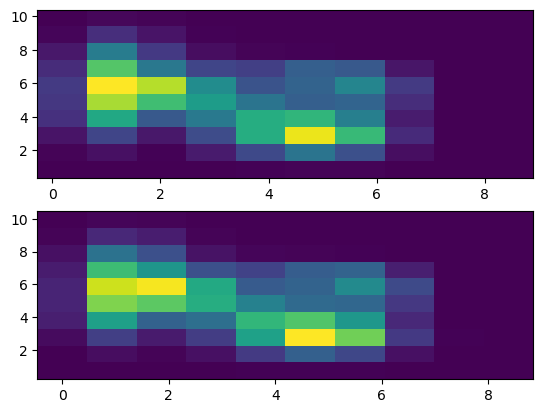

In [62]:
fig, ax = plt.subplots(2)
ax[0].hist2d(z[:,0,0], z[:,1,0])
ax[1].hist2d(sampled_data[:,0,0], sampled_data[:,1,0])

(array([[0.00000e+00, 2.00000e+00, 2.70000e+01, 2.37000e+02, 5.28000e+02,
         8.49000e+02, 6.51000e+02, 1.33000e+02, 1.60000e+01, 1.00000e+00],
        [0.00000e+00, 7.34000e+02, 4.69000e+03, 1.24490e+04, 2.30140e+04,
         3.22910e+04, 2.21030e+04, 4.09800e+03, 3.14000e+02, 2.90000e+01],
        [1.00000e+00, 5.68500e+03, 3.29650e+04, 6.19760e+04, 1.03150e+05,
         9.66690e+04, 5.46140e+04, 9.67400e+03, 5.18000e+02, 1.30000e+01],
        [3.70000e+02, 1.13870e+04, 3.81070e+04, 6.09420e+04, 1.11683e+05,
         1.18632e+05, 5.31490e+04, 1.43720e+04, 1.77000e+02, 1.10000e+01],
        [5.00900e+03, 3.67030e+04, 4.84120e+04, 6.40100e+04, 1.22868e+05,
         9.73140e+04, 4.59630e+04, 1.30980e+04, 9.10000e+01, 1.00000e+00],
        [7.42600e+03, 4.29450e+04, 6.32210e+04, 8.15370e+04, 1.49055e+05,
         8.50170e+04, 4.27960e+04, 5.87100e+03, 1.23000e+02, 2.00000e+00],
        [1.82800e+03, 1.15850e+04, 2.31310e+04, 7.01010e+04, 1.03992e+05,
         5.08740e+04, 3.13330e+0

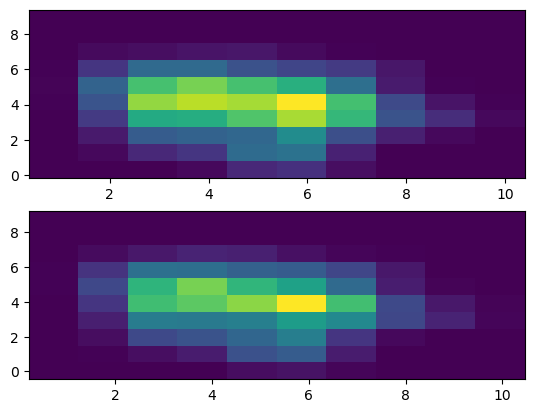

In [63]:
fig, ax = plt.subplots(2)
ax[0].hist2d(z[:,1,0], z[:,2,0])
ax[1].hist2d(sampled_data[:,1,0], sampled_data[:,2,0])

(array([[2.50000e+01, 4.55000e+02, 3.65100e+03, 6.33800e+03, 3.16100e+03,
         7.77000e+02, 1.87000e+02, 3.80000e+01, 1.00000e+00, 1.00000e+00],
        [2.33000e+02, 3.95000e+03, 2.78280e+04, 4.92350e+04, 2.18650e+04,
         4.72000e+03, 1.02000e+03, 1.71000e+02, 1.90000e+01, 1.00000e+00],
        [5.75000e+02, 1.21060e+04, 5.61400e+04, 9.24000e+04, 4.20590e+04,
         8.70300e+03, 1.90500e+03, 3.13000e+02, 4.50000e+01, 2.00000e+00],
        [3.46400e+03, 6.43250e+04, 1.19552e+05, 1.32315e+05, 6.55990e+04,
         1.16840e+04, 2.27700e+03, 3.94000e+02, 5.20000e+01, 1.00000e+00],
        [5.12100e+03, 9.08670e+04, 1.83952e+05, 2.52769e+05, 1.07924e+05,
         1.50970e+04, 1.78500e+03, 2.44000e+02, 2.30000e+01, 0.00000e+00],
        [5.39500e+03, 8.60740e+04, 1.49690e+05, 1.85844e+05, 6.11560e+04,
         6.22500e+03, 2.00000e+02, 1.50000e+01, 0.00000e+00, 0.00000e+00],
        [3.56200e+03, 6.74890e+04, 1.02477e+05, 6.44240e+04, 2.10680e+04,
         1.32100e+03, 1.80000e+0

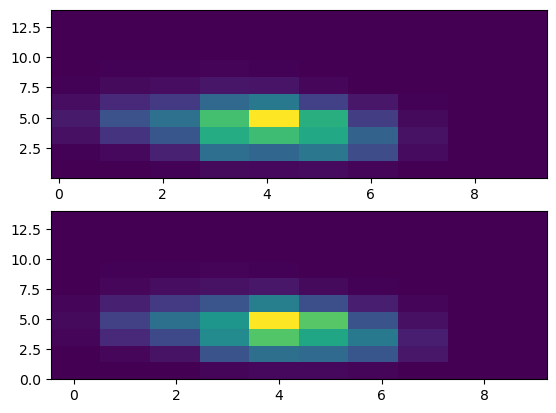

In [64]:
fig, ax = plt.subplots(2)
ax[0].hist2d(z[:,2,0], z[:,3,0])
ax[1].hist2d(sampled_data[:,2,0], sampled_data[:,3,0])

In [65]:
z[0], sampled_data[0]

(array([[1.3693246],
        [7.0166526],
        [5.5883117],
        [4.576757 ],
        [6.110545 ],
        [3.5310822]], dtype=float32),
 array([[1.21241062],
        [5.53984253],
        [2.45130998],
        [6.73225042],
        [9.96962245],
        [1.14788519]]))